In [1]:
import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import sys, cv2, pickle, math, os
import numpy as np
from numpy import argmax
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir 
from os.path import isfile, join
from tifffile import imread, imsave
from glob import glob

np.random.seed(109)


import logging
logger = logging.getLogger()  # Logger

logger.setLevel("INFO")
#logging.info("Hello")

In [2]:
def write_pickle(path, obj):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
        
def read_pickle(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

In [3]:
df_dataset = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/SVM/df_combined_incept.pkl")

In [4]:
print(df_dataset.head())

             Img         lbl  \
0  18QH2FGR4_270  non-cancer   
1  18QH2FGR4_324  non-cancer   
2  18QH2FGR4_322  non-cancer   
3  18QH2FGR4_397  non-cancer   
4  18QH2FGR4_436  non-cancer   

                                            Features  
0  [0.17763883, 0.14930727, 0.099433355, 0.046645...  
1  [0.2863244, 0.029040584, 0.13237323, 0.0353634...  
2  [0.25656575, 0.19232213, 0.34882596, 0.2506054...  
3  [0.07404756, 0.05178327, 0.018168312, 0.131144...  
4  [0.10449956, 0.085279934, 0.0015779797, 0.0874...  


In [5]:
X = df_dataset["Features"].to_list()
y = df_dataset["lbl"]

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)

[1 1 1 ... 1 1 0]


non-cancer    1817
cancer         965
Name: lbl, dtype: int64


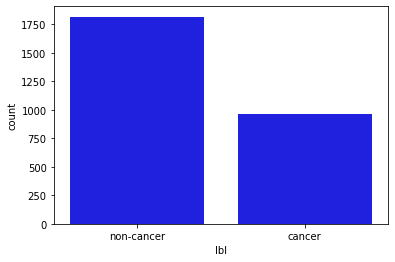

In [7]:
sns.countplot(data=df_dataset, x="lbl", color="blue")
plt.savefig('classdistribution_count.png')
print(df_dataset["lbl"].value_counts())

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 930, 0: 391})
Testing target statistics: Counter({1: 226, 0: 105})


In [9]:
def build_and_test(X_tr, X_te, y_tr, y_te, plot_dir:str, model_name:str, threshold=False, scaler:str='', balancer:str=''):
    print( model_name, scaler, balancer, threshold)

    direct = os.path.join(plot_dir, model_name, scaler, balancer, 'Threshold' if threshold else '') 
    os.makedirs(direct, exist_ok=True)

    #scale data
    if scaler == 'StandardScaler':
        std_scaler = StandardScaler().fit(X_tr + X_te)
        X_tr_scaled = std_scaler.transform(X_tr)
        X_te_scaled = std_scaler.transform(X_te)
    elif scaler == 'MinMaxScaler':
        minmax_scaler = MinMaxScaler().fit(X_tr + X_te)
        X_tr_scaled = minmax_scaler.transform(X_tr)
        X_te_scaled = minmax_scaler.transform(X_te)
    else:
        X_tr_scaled = X_tr
        X_te_scaled = X_te
    
    
    #balance dataset
    if balancer == 'RandomOversampler':
        over_sampler = RandomOverSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = over_sampler.fit_resample(X_tr_scaled, y_tr)
    elif balancer == 'RandomUndersampler':
        under_sampler = RandomUnderSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = under_sampler.fit_resample(X_tr_scaled, y_tr)
    else:
        X_tr_sampled, y_tr_sampled = X_tr_scaled, y_tr
    
    
    #build model
    if model_name == 'SVM':
        model = svm.SVC(kernel="linear", C=1.0, probability=True)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(max_iter=1500)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    else:
        print(f'WARNING no {model} model found!')
        
    #print metrices    
    result_dic = {f'Model': model,
                  f'Balancer': balancer,
                  f'Scaler': scaler,
                  f'Precision score': precision_score(y_te, y_pred),
                  f'Recall score':  recall_score(y_te, y_pred),
                  f'F1-score score': f1_score(y_te, y_pred),
                  f'Accuracy score': accuracy_score(y_te, y_pred),
                  f'Area under the ROC curve (AUC)': roc_auc_score(y_te, y_pred)}

    
    y_score = model.predict_proba(X_te)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)
    
    # Calculate the best threshold
    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J) # take the value which maximizes the J variable
        best_threshold = thresholds[ix]
        # adjust score according to threshold.
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
        
    
    result_dic['cm'] = confusion_matrix(y_te, y_pred)
    
    
       
    # Plot metrics 
    plot_roc(y_te, y_score)
    plt.title(f'ROC curve of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
    plt.tight_layout()
    plt.savefig(os.path.join(direct, 'roc.png'))
    plt.clf()
    plt.close()

    
    plot_precision_recall(y_te, y_score)
    plt.title(f'Precision Recall curve of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
    plt.tight_layout()
    plt.savefig(os.path.join(direct, 'precision_recall.png'))
    plt.clf()
    plt.close()

    
    plot_confusion_matrix(y_te, y_pred, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(os.path.join(direct, 'Confusion_Matrix.png'))
    plt.clf()
    plt.close()
    
    # Print a classification report
    result_dic['classification_report'] = classification_report(y_te, y_pred)
                
    return result_dic

In [10]:
plot_dir = '/mnt/DataRAID/melismail/Preprocessing/data/Classification/Vgg/2class/'
balancer_list = ['RandomOversampler', 'RandomUndersampler', '']
scaler_list = ['MinMaxScaler', 'StandardScaler', '']
ml_model_list = ['SVM', 'LogisticRegression']
threshold_list = [True, False]

classification_dic  = [build_and_test(X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test, plot_dir=plot_dir, model_name = m, threshold=t, scaler=s, balancer=b)
                       for s in scaler_list
                       for b in balancer_list
                       for m in ml_model_list
                       for t in threshold_list]

SVM MinMaxScaler RandomOversampler True
SVM MinMaxScaler RandomOversampler False
LogisticRegression MinMaxScaler RandomOversampler True
LogisticRegression MinMaxScaler RandomOversampler False
SVM MinMaxScaler RandomUndersampler True
SVM MinMaxScaler RandomUndersampler False
LogisticRegression MinMaxScaler RandomUndersampler True
LogisticRegression MinMaxScaler RandomUndersampler False
SVM MinMaxScaler  True
SVM MinMaxScaler  False
LogisticRegression MinMaxScaler  True
LogisticRegression MinMaxScaler  False
SVM StandardScaler RandomOversampler True
SVM StandardScaler RandomOversampler False
LogisticRegression StandardScaler RandomOversampler True
LogisticRegression StandardScaler RandomOversampler False
SVM StandardScaler RandomUndersampler True
SVM StandardScaler RandomUndersampler False
LogisticRegression StandardScaler RandomUndersampler True
LogisticRegression StandardScaler RandomUndersampler False
SVM StandardScaler  True
SVM StandardScaler  False
LogisticRegression StandardScaler

In [11]:
write_pickle(path='/mnt/DataRAID/melismail/Preprocessing/data/Classification/classification_vgg.pkl', obj=classification_dic)